# Wheat Disease Detection
# 1.1 Introduction
In this iPython notebook, we will explore the use of advanced neural network models such as VGG19, Xception, and InceptionV3 to detect diseases in wheat plants. By leveraging pre-trained weights from ImageNet, we can accelerate training and improve model performance for this computer vision task.

# The workflow involves:
Importing and loading essential libraries for image processing and model training.
Preprocessing images and making them compatible with Keras.
Training the neural networks to classify wheat images as healthy or diseased.

This approach provides an efficient pipeline for detecting diseases in wheat plants using deep learning.

# 1.2 Metrics
To evaluate the performance of our models, we will use the following metrics:

Categorical Cross-Entropy Loss: Measures how well the predicted probability distribution aligns with the true labels.
Accuracy: The proportion of correctly classified images over the total images.

# 1.3 Classes

The dataset consists of images classified into four categories:
1.Leaf Rust

2.Crown and Root Rot

3.Healthy Wheat

4.Wheat Loose Smut

Each class contains approximately 4,500 images. For evaluation, 20% of the data will be used as the test set using stratified sampling to ensure balanced representation of all classes.

# Importing Libraries

The following libraries will be used to facilitate image preprocessing, model training, and evaluation:

TensorFlow & Keras – for building and training neural networks

NumPy & Pandas – for numerical operations and data handling

Matplotlib & Seaborn – for visualization

Scikit-learn – for data splitting and evaluation metrics

These libraries provide a robust framework for implementing convolutional neural networks and handling image data efficiently.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
import cv2
import os 
import pickle
from imutils import paths
from tqdm import tqdm
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import Xception, ResNet152, InceptionV3, NASNetLarge
%matplotlib inline

In [4]:
LABELS = set(["Crown and Root Rot", "Healthy Wheat", "Leaf Rust", "Wheat Loose Smut"])


In [5]:
from imutils import paths
count = 0
for image_path in paths.list_images('/kaggle/input/dataset/Dataset/Crown and Root Rot'):
    print(image_path)
    count += 1
    if count == 5:
        break


/kaggle/input/dataset/Dataset/Crown and Root Rot/02371.jpg
/kaggle/input/dataset/Dataset/Crown and Root Rot/02621.jpg
/kaggle/input/dataset/Dataset/Crown and Root Rot/00091.jpg
/kaggle/input/dataset/Dataset/Crown and Root Rot/08171.jpg
/kaggle/input/dataset/Dataset/Crown and Root Rot/04211.jpg


In [6]:
image = cv2.imread('/kaggle/input/dataset/Dataset/Crown and Root Rot/02371.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))


In [7]:
#We find a way to get the name of the image to be used from paths.
sample_path=list(paths.list_images('/kaggle/input/dataset/Dataset/Crown and Root Rot'))[0]

In [8]:
sample_path

'/kaggle/input/dataset/Dataset/Crown and Root Rot/02371.jpg'

In [9]:
#Let us now split the path to get our desired result of the image.
sample_path.split('/')

['',
 'kaggle',
 'input',
 'dataset',
 'Dataset',
 'Crown and Root Rot',
 '02371.jpg']

In [10]:
import os
dataset_path = '/kaggle/input/dataset/Dataset'  # where your zip was extracted
Labels = os.listdir(dataset_path)
print("Class folders:", Labels)


Class folders: ['Healthy Wheat', 'Wheat Loose Smut', 'Leaf Rust', 'Crown and Root Rot']


In [11]:
CROWN_AND_ROOT_ROT_PATH ='/kaggle/input/dataset/Dataset/Crown and Root Rot'
HEALTHY_AND_WHEAT_PATH = '/kaggle/input/dataset/Dataset/Healthy Wheat'
LEAF_RUST_PATH = '/kaggle/input/dataset/Dataset/Leaf Rust'
WHEAT_LOOSE_SMUT_PATH = '/kaggle/input/dataset/Dataset/Wheat Loose Smut'

In [12]:
data = []
labels = []
for image_path in tqdm(paths.list_images(CROWN_AND_ROOT_ROT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
for image_path in tqdm(paths.list_images(HEALTHY_AND_WHEAT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)

for image_path in tqdm(paths.list_images(LEAF_RUST_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
for image_path in tqdm(paths.list_images(WHEAT_LOOSE_SMUT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    

86it [00:01, 89.97it/s]libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
656it [00:06, 94.69it/s] libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
869it [00:09, 88.96it/s] libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
1021it [00:10, 96.53it/s]
1146it [00:30, 37.52it/s]
84it [00:06, 12.58it/s]
930it [00:13, 70.18it/s] 


In [13]:
labels[-1]

'Wheat Loose Smut'

# Transfer Learning
Transfer learning is a method in deep learning where a model that is developed for a particular task is reused as the starting point for our model so that we get it for our use cases.

In the below cells, transfer learning is applied which ensures that models are not trained from the start. Instead only the last few layers for our application are trained. This leads to a good reduction in the time taken to train them. Furthermore, this leads to a good improvement in the accuracy of the model as state-of-the-art models are taken for training the models.

# VGG19 Network
VGG19 nework trained on imagenet weights is taken as our base model. In addition to this network, we add more layers so that the final model is used for our task of detecting and identifying wheat diseases.

In [14]:
headmodel = VGG19(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (224, 224, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False


I0000 00:00:1767528685.929801      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767528685.933557      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [15]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-3)  # 'lr' is deprecated in TF 2.x
final_model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)


In [16]:
data = np.array(data)
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [17]:
labels[0]

array([1, 0, 0, 0])

In [18]:
X_train, X_cv, y_train, y_cv = train_test_split(data, labels, test_size = 0.2,
                                                    stratify = labels, random_state = 101)

In [19]:
len(X_train)

2544

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2443067074339137870
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619443200
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16164530078235866849
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14619443200
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2940995245039556786
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


I0000 00:00:1767528828.526537      55 gpu_device.cc:2019] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767528828.526778      55 gpu_device.cc:2019] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [21]:
fitted_model = final_model.fit(X_train, y_train, validation_data = (X_cv, y_cv), 
               epochs = 30, batch_size = 64)

Epoch 1/30


I0000 00:00:1767528831.224086     127 service.cc:152] XLA service 0x7b503c013350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767528831.224138     127 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767528831.224148     127 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767528831.734216     127 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767528855.399446     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5613 - loss: 2.7129 - val_accuracy: 0.7896 - val_loss: 0.6366
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.8356 - loss: 0.5369 - val_accuracy: 0.8556 - val_loss: 0.4251
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.8927 - loss: 0.3124 - val_accuracy: 0.8980 - val_loss: 0.3010
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 492ms/step - accuracy: 0.9354 - loss: 0.1947 - val_accuracy: 0.9152 - val_loss: 0.2750
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.9560 - loss: 0.1461 - val_accuracy: 0.9309 - val_loss: 0.2163
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - accuracy: 0.9669 - loss: 0.1055 - val_accuracy: 0.9403 - val_loss: 0.2234
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.9732 - loss: 0.0899 - val_accuracy: 0.9560 - val_loss: 0.1981
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 492ms/step - accuracy: 0.9744 - loss: 0.0796 - val_accuracy: 0.9388 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step


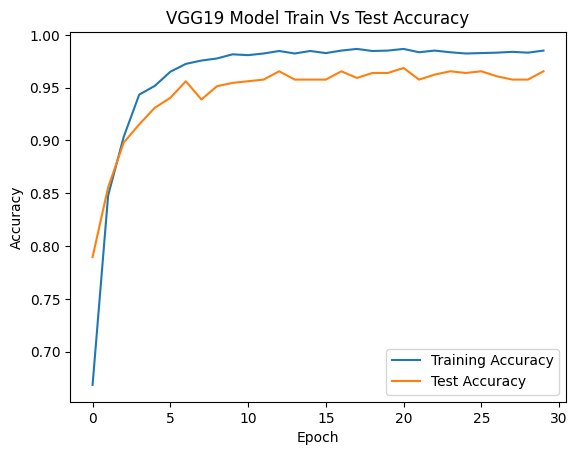

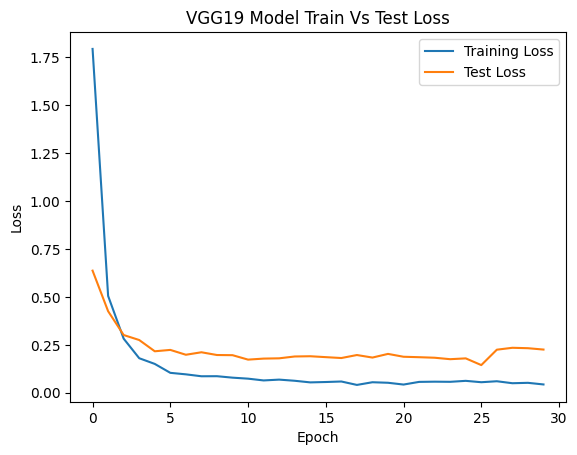

<Figure size 640x480 with 0 Axes>

In [22]:
predictions = final_model.predict(X_cv, batch_size = 64)
N = 30
plt.plot(np.arange(0, N), fitted_model.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.arange(0, N), fitted_model.history['val_accuracy'], label = "Test Accuracy")
plt.title('VGG19 Model Train Vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.show()
plt.savefig(r"D:\Project\Wheat main\Images\VGG19_accuracy_plots.png")

plt.plot(fitted_model.history['loss'], label = "Training Loss")
plt.plot(fitted_model.history['val_loss'], label = "Test Loss")
plt.title("VGG19 Model Train Vs Test Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.show()
plt.savefig(r"D:\Project\Wheat main\Images\VGG19_loss_plot.png")

In [23]:
import os
print(os.listdir('/kaggle'))

['lib', 'input', 'working']


In [24]:
final_model.save('/kaggle/working/wheat_model.h5')


In [29]:
data = []
labels = []
for image_path in tqdm(paths.list_images(CROWN_AND_ROOT_ROT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
for image_path in tqdm(paths.list_images(HEALTHY_AND_WHEAT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)

for image_path in tqdm(paths.list_images(LEAF_RUST_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)
    
for image_path in tqdm(paths.list_images(WHEAT_LOOSE_SMUT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    data.append(image)
    
    label = image_path.split('/')[-2]
    
    labels.append(label)

88it [00:02, 81.37it/s]libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
660it [00:05, 172.11it/s]libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
866it [00:06, 166.95it/s]libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
1021it [00:07, 131.62it/s]
1146it [00:20, 55.79it/s]
84it [00:05, 15.09it/s]
930it [00:07, 120.12it/s]


In [31]:
data = np.array(data)
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [32]:
X_train, X_cv, y_train, y_cv = train_test_split(data, labels, test_size = 0.2,
                                                    stratify = labels, random_state = 101)

## Xception Network
It is now time to train an xception network to see how the training accuracy and the cross-validation accuracy increases with increase in the number of epochs.

As could be seen below from the architecture, the input shape that is accepted by Xception network is (299, 299, 3). Therefore, we did a good thing in the above cells in resizing the images to be of (299, 299) shape.

In [33]:
headmodel = Xception(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (299, 299, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
opt = Adam(learning_rate = 1e-3)
final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [35]:

fitted_model = final_model.fit(X_train, y_train, validation_data = (X_cv, y_cv), 
               epochs = 30, batch_size = 64)

Epoch 1/30


2026-01-03 16:35:27.154919: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.76 = (f32[64,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,147,147]{3,2,1,0} %bitcast.7672, f32[64,1,3,3]{3,2,1,0} %bitcast.7586), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="functional_2_1/block2_sepconv1_1/separable_conv2d/depthwise" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-01-03 16:35:27.260414: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.105625887s
Trying algo

39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4176 - loss: 52.8924

2026-01-03 16:36:31.051318: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.78 = (f32[48,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[48,128,147,147]{3,2,1,0} %bitcast.7627, f32[128,1,3,3]{3,2,1,0} %bitcast.7631), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="functional_2_1/block2_sepconv2_1/separable_conv2d/depthwise" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-01-03 16:36:31.666634: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.615447727s
Trying 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4193 - loss: 52.6010   

2026-01-03 16:37:21.582029: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.76 = (f32[61,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[61,64,147,147]{3,2,1,0} %bitcast.4906, f32[64,1,3,3]{3,2,1,0} %bitcast.4820), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="functional_2_1/block2_sepconv1_1/separable_conv2d/depthwise" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-01-03 16:37:21.612761: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.030844778s
Trying algo

40/40 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.4209 - loss: 52.3238 - val_accuracy: 0.5699 - val_loss: 13.4638
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 566ms/step - accuracy: 0.5780 - loss: 10.5799 - val_accuracy: 0.6531 - val_loss: 0.9461
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 573ms/step - accuracy: 0.6705 - loss: 0.8975 - val_accuracy: 0.6954 - val_loss: 0.7292
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 565ms/step - accuracy: 0.7279 - loss: 0.6533 - val_accuracy: 0.7630 - val_loss: 0.6737
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 569ms/step - accuracy: 0.7839 - loss: 0.5659 - val_accuracy: 0.7896 - val_loss: 0.5827
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 570ms/step - accuracy: 0.8301 - loss: 0.4490 - val_accuracy: 0.8226 - val_loss: 0.5758
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 570ms/step - accuracy: 0.8504 - loss: 0.4041 - val_accuracy: 0.8383 - val_loss: 0.5015
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 570ms/step - accuracy: 0.8779 - loss: 0.3350 - val_accuracy: 0.88

# InceptionV3 Network
In the below cells, InceptionV3 network would be implemented with the weights taken from imagenet data. Inception weights are not trained and additional layers that are added on top of inception are trained to help us get the output for our prediction of disease in wheat.

In [36]:
headmodel = InceptionV3(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (299, 299, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dense(256, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False
    

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
opt = Adam(learning_rate=1e-3)

final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [38]:
fitted_model = final_model.fit(X_train, y_train, validation_data = (X_cv, y_cv), 
               epochs = 30, batch_size = 64)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3658 - loss: 21.4572 - val_accuracy: 0.5432 - val_loss: 1.4091
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.5061 - loss: 1.4794 - val_accuracy: 0.5542 - val_loss: 1.1406
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.5993 - loss: 1.0003 - val_accuracy: 0.6405 - val_loss: 0.9991
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.6155 - loss: 0.9077 - val_accuracy: 0.5950 - val_loss: 1.0168
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.6464 - loss: 0.8373 - val_accuracy: 0.6436 - val_loss: 0.9455
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.6799 - loss: 0.7813 - val_accuracy: 0.6735 - val_loss: 0.8725
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.7233 - loss: 0.7167 - val_accuracy: 0.7190 - val_loss: 0.8773
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.7531 - loss: 0.6388 - val_accura

# ResNet152 Network
ResNet152 is used to check the performance of the models. Sometimes we are under the assumption that adding more layers in the neural network would reduce the training and test loss.

According to experiments, however, we see that adding more layers in our network would not decrease the training loss to a large extent.

Below is the implementation of ResNet152 Network. Feel free to take a look.

In [39]:
headmodel = ResNet152(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (299, 299, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.1)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [40]:
opt = Adam(learning_rate=1e-3)

final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

fitted_model = final_model.fit(X_train, y_train, validation_data = (X_cv, y_cv), 
               epochs = 30, batch_size = 64)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.4974 - loss: 5.2351 - val_accuracy: 0.7755 - val_loss: 0.6270
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8253 - loss: 0.4738 - val_accuracy: 0.8681 - val_loss: 0.3603
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 994ms/step - accuracy: 0.9348 - loss: 0.2305 - val_accuracy: 0.9419 - val_loss: 0.2308
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9689 - loss: 0.1344 - val_accuracy: 0.9482 - val_loss: 0.1542
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9716 - loss: 0.0894 - val_accuracy: 0.9608 - val_loss: 0.1380
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9863 - loss: 0.0546 - val_accuracy: 0.9717 - val_loss: 0.1349
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9857 - loss: 0.0484 - val_accuracy: 0.9639 - val_loss: 0.1346
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9845 - loss: 0.0459 - val_accuracy: 0.9686 - val_l